In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
from scipy import stats
from aisynphys.database import default_db as db
from aisynphys.cell_class import CellClass, classify_cells, classify_pairs
from aisynphys.connectivity import measure_connectivity, connectivity_profile, pair_was_probed, measure_distance
from aisynphys.ui.notebook import compose_svg_figure
from pandas.plotting import table
matplotlib.rcParams['font.sans-serif'] = "Arial"
print("db version: %s" % db.schema_version)

db version: 21


### Fig S8 Comparison of connectivity, strength, and STP in two external calcium concentrations (2mM & 1.3mM) in mouse

In [2]:
high_ca_pairs = db.pair_query(species='mouse', acsf='2mM Ca & Mg').all()
low_ca_pairs = db.pair_query(species='mouse', acsf='1.3mM Ca & 1mM Mg').all()

In [3]:
cell_class_criteria = {
    'l23pyr': {'dendrite_type': 'spiny', 'cortical_layer': '2/3'},
    'l5et':   {'cre_type': 'sim1', 'cortical_layer': '5'},
    'l5it':   {'cre_type': 'tlx3', 'cortical_layer': '5'}, 
    'l5pv':   {'cre_type': 'pvalb', 'cortical_layer': '5'},
    'l5sst':  {'cre_type': 'sst', 'cortical_layer': '5'},
    'l5vip':  {'cre_type': 'vip', 'cortical_layer': '5'},
    'l6pyr':  {'cre_type': 'ntsr1', 'cortical_layer': ('6', '6a', '6b')}
}

mouse_cell_classes = {name:CellClass(name=name, **criteria) for name,criteria in cell_class_criteria.items()}

In [4]:
high_cell_groups = classify_cells(mouse_cell_classes.values(), pairs=high_ca_pairs, missing_attr='ignore')
low_cell_groups = classify_cells(mouse_cell_classes.values(), pairs=low_ca_pairs, missing_attr='ignore')

high_pair_groups = classify_pairs(high_ca_pairs, high_cell_groups)
low_pair_groups = classify_pairs(low_ca_pairs, low_cell_groups)

high_cp = measure_connectivity(high_pair_groups)
low_cp = measure_connectivity(low_pair_groups)

In [5]:
from aisynphys.ui.notebook import heatmap, annotate_heatmap
from scipy.stats import fisher_exact

def matrix_compare(ax, results1, results2, pre_cell_classes, post_cell_classes, class_labels, cmap,norm, alpha=True):
    shape = (len(pre_cell_classes), len(post_cell_classes))
    cprob1 = np.zeros(shape)
    cprob1_alpha = np.zeros(shape)
    cprob1_str = np.zeros(shape, dtype=object)
    cprob2 = np.zeros(shape)
    cprob2_alpha = np.zeros(shape)
    cprob2_str = np.zeros(shape, dtype=object)
   
    stats = np.zeros(shape)

    for i,pre_class in enumerate(pre_cell_classes):
        for j,post_class in enumerate(post_cell_classes):
            result1 = results1[pre_class, post_class]
            result2 = results2[pre_class, post_class]
            if result1['n_probed'] == 0 or result2['n_probed'] == 0:
                cprob1_str[i,j] = ''
                cprob2_str[i,j] = ''
                continue
            cp, cp_lower_ci, cp_upper_ci = result1['connection_probability']
            cprob1[i,j] = cp
            cprob1_alpha[i,j] = 1.0 - 2.0 * (cp_upper_ci - cp_lower_ci)
            conn1 = result1['n_connected']
            unconn1 = result1['n_probed'] - conn1
            cprob1_str[i,j] = "%d/%d" % (result1['n_connected'], result1['n_probed'])
            cp, cp_lower_ci, cp_upper_ci = result2['connection_probability']
            cprob2[i,j] = cp 
            cprob2_alpha[i,j] = 1.0 - 2.0 * (cp_upper_ci - cp_lower_ci)
            conn2 = result2['n_connected']
            unconn2 = result2['n_probed'] - conn2
            cprob2_str[i,j] = "%d/%d" % (result2['n_connected'], result2['n_probed'])
            
            _, stats[i,j] = fisher_exact([[conn1, unconn1], [conn2, unconn2]])

    # map connection probability to RGB colors
    mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    cprob1_rgba = mapper.to_rgba(np.clip(cprob1, 0.01, 1.0))
    cprob2_rgba = mapper.to_rgba(np.clip(cprob2, 0.01, 1.0))

    # apply alpha based on confidence intervals
    if alpha:
        cprob1_rgba[:, :, 3] = np.clip(cprob1_alpha, 0, 1)
        cprob2_rgba[:, :, 3] = np.clip(cprob2_alpha, 0, 1)

    # generate lists of labels to display along the pre- and postsynaptic axes
    pre_class_labels = [class_labels[cls] for cls in pre_cell_classes]
    post_class_labels = [class_labels[cls] for cls in post_cell_classes]

    # draw the heatmap with axis labels and colorbar
    im, _ = heatmap(cprob1_rgba, pre_class_labels, post_class_labels, ax=ax[0], 
        ax_labels=('postsynaptic', 'presynaptic'),
        bg_color=(0.7, 0.7, 0.7),
        cmap=cmap, 
        norm=norm,
#         cbarlabel="Connection probability", 
        cbar_kw={'shrink':0})
    _ = annotate_heatmap(im, cprob1_str, data=cprob1)
            
    im, _ = heatmap(cprob2_rgba, pre_class_labels, post_class_labels, ax=ax[1], 
#         ax_labels=('postsynaptic', 'presynaptic'),
        bg_color=(0.7, 0.7, 0.7),
        cmap=cmap, norm=norm, 
        cbarlabel="Connection probability", 
        cbar_kw={'shrink':0.5})
    _ = annotate_heatmap(im, cprob2_str, data=cprob2)

    # draw text over each matrix element
#     labels = annotate_heatmap(im, cprob_str, data=cprob)
    
    return cprob1, cprob2, stats

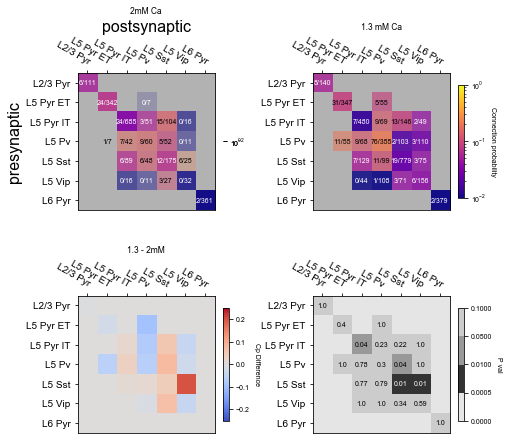

In [6]:
import matplotlib.colors, matplotlib.cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
from aisynphys.ui.notebook import show_connectivity_matrix, annotate_heatmap
%matplotlib inline

# define a colormap and log normalization used to color the heatmap
norm = matplotlib.colors.LogNorm(vmin=0.01, vmax=1.0, clip=True)
cmap = matplotlib.cm.get_cmap('plasma')

# define the display labels to use for each cell subclass:
mouse_class_labels = {
    'l23pyr': 'L2/3 Pyr',
    'l5et':   'L5 Pyr ET',
    'l5it':   'L5 Pyr IT',
    'l5pv':   'L5 Pv',
    'l5sst':  'L5 Sst',
    'l5vip':  'L5 Vip',
    'l6pyr':  'L6 Pyr',
}

# create a figure/axes to draw on
S8A, ax = plt.subplots(2, 2, figsize=(7,7))

plt.rcParams.update({'font.size': 7})
plt.tight_layout(w_pad=1, h_pad=0.5)
# plt.subplots_adjust(wspace=0.5, top=0.5)

# finally, draw the colormap using the provided function:
cprob_high, cprob_low, cp_stats = matrix_compare(
    ax=[ax[0, 0], ax[0, 1]], 
    results1=high_cp, 
    results2=low_cp,
    pre_cell_classes=mouse_cell_classes.values(), 
    post_cell_classes=mouse_cell_classes.values(), 
    class_labels=mouse_class_labels, 
    cmap=cmap, 
    norm=norm,
)


ax[0, 0].set_title('2mM Ca')
ax[0, 1].set_title('1.3 mM Ca')
ax[1, 0].set_title('1.3 - 2mM')

cp_diff = cprob_high - cprob_low
cmap_diff = matplotlib.cm.get_cmap('coolwarm') 
norm_diff = matplotlib.colors.Normalize(vmin=-0.25, vmax=0.25, clip=False)
mapper = matplotlib.cm.ScalarMappable(norm=norm_diff, cmap=cmap_diff)
diff_rgba = mapper.to_rgba(cp_diff)
heatmap(diff_rgba, mouse_class_labels.values(), mouse_class_labels.values(), ax=ax[1, 0],
        cmap=cmap_diff, norm=norm_diff, 
        cbarlabel="Cp Difference", 
        cbar_kw={'shrink':0.5})

grey = matplotlib.colors.ListedColormap([(0.9, 0.9, 0.9), (0.2, 0.2, 0.2), (0.4, 0.4, 0.4), (0.6, 0.6, 0.6), (0.8, 0.8, 0.8)])

bounds = [0, 0.0005, 0.01, 0.05, 0.1]
norm_stat = matplotlib.colors.BoundaryNorm(bounds, len(bounds)+1, clip=False)
mapper = matplotlib.cm.ScalarMappable(norm=norm_stat, cmap=grey)
stat_rgba = mapper.to_rgba(cp_stats)
im, cbar = heatmap(stat_rgba, mouse_class_labels.values(), mouse_class_labels.values(), ax=ax[1,1],
        cmap=grey, norm=norm_stat, 
        cbarlabel="P val", 
        cbar_kw={'shrink':0.5})

stat_str = np.round(cp_stats, decimals=2)
stat_str = stat_str.astype('str')
stat_str[stat_str=='0.0']=''
_ = annotate_heatmap(im, stat_str, data=cp_stats)
plt.tight_layout(h_pad=-0.1)

In [7]:
mouse_pairs = None
for pre_name, pre_class in mouse_cell_classes.items():
    for post_name, post_class in mouse_cell_classes.items():
        pair_query = db.pair_query(
            species='mouse',
            pre_class=pre_class,
            post_class=post_class,
            synapse=True,
        )
        
        pair_query = pair_query.add_columns(
            db.Experiment.acsf,
            db.Synapse.psp_amplitude,
            db.Dynamics.pulse_amp_90th_percentile,
            db.Dynamics.stp_induction_50hz
        )
        
        df = pair_query.dataframe(rename_columns=False)
        df['pre_class'] = pre_name
        df['post_class'] = post_name
        df['pair_class'] = pre_name + "→" + post_name
        
        if mouse_pairs is None:
            mouse_pairs = df
        else:
            mouse_pairs = mouse_pairs.append(df)

In [8]:
# filter for elements that have sufficient data in both calcium concentrations, 
# in this case at least 2 pairs in each condition

def get_both_groups(pair_df):
    acsf_count = pair_df.groupby(['acsf', 'pair_class']).size().reset_index(name='count')
    high_groups = acsf_count[(acsf_count['acsf']=='2mM Ca & Mg') & (acsf_count['count']>1)]
    high_groups = high_groups['pair_class']
    low_groups = acsf_count[(acsf_count['acsf']=='1.3mM Ca & 1mM Mg') & (acsf_count['count']>1)]
    low_groups = low_groups['pair_class']
    both_groups = pd.merge(high_groups, low_groups, how='inner')['pair_class']
    return both_groups
# pairs2 = mouse_pairs[mouse_pairs['pair_class'].isin(both_groups)]

In [9]:
import seaborn as sns
from scipy import stats
order = ['2mM Ca & Mg', '1.3mM Ca & 1mM Mg']
S8B, ax = plt.subplots(3, 1, figsize=(4,6))
[x.axhline(color='k', linestyle='--', linewidth=1) for x in ax]
plt.xticks(rotation=45, ha='right')
plt.rcParams.update({'font.size': 7})

pairs_amp = mouse_pairs[~mouse_pairs['psp_amplitude'].isnull()]
amp_groups = get_both_groups(pairs_amp)
pairs_amp_90 = mouse_pairs[~mouse_pairs['pulse_amp_90th_percentile'].isnull()]
amp_90_groups = get_both_groups(pairs_amp_90)
pairs_stp = mouse_pairs[~mouse_pairs['stp_induction_50hz'].isnull()]
stp_groups = get_both_groups(pairs_stp)

all_groups = pd.merge(amp_groups, amp_90_groups, how='inner')
all_groups = pd.merge(all_groups, stp_groups, how='inner')['pair_class']

pairs_amp = pairs_amp[pairs_amp['pair_class'].isin(all_groups)]
pairs_amp['psp_amplitude'] = pairs_amp['psp_amplitude'].astype('float64')
sns.violinplot(x='pair_class', y='psp_amplitude', data=pairs_amp, hue='acsf', split=True, 
            scale='width', inner='stick', hue_order=order, ax=ax[0])
ax[0].set_xticklabels('')

pairs_amp_90 = pairs_amp_90[pairs_amp_90['pair_class'].isin(all_groups)]
pairs_amp_90['pulse_amp_90th_percentile'] = pairs_amp_90['pulse_amp_90th_percentile'].astype('float64')
sns.violinplot(x='pair_class', y='pulse_amp_90th_percentile', data=pairs_amp_90, hue='acsf', split=True, 
               scale='width', inner='stick', hue_order=order, ax=ax[1], legend=False)
ax[1].set_xticklabels('')


pairs_stp = pairs_stp[pairs_stp['pair_class'].isin(all_groups)]
pairs_stp['stp_induction_50hz'] = pairs_stp['stp_induction_50hz'].astype('float64')
sns.violinplot(x='pair_class', y='stp_induction_50hz', data=pairs_stp, hue='acsf', split=True, 
               scale='width', inner='stick', hue_order=order, ax=ax[2])

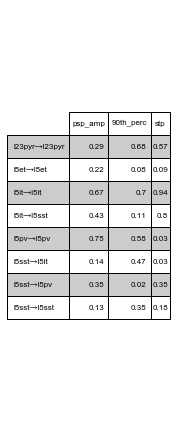

In [10]:
from pandas.plotting import table
amp_stats = {}
amp_90_stats ={}
stp_stats = {}

for pc in all_groups:
    amp_high = pairs_amp[(pairs_amp['pair_class']==pc) & (pairs_amp['acsf']=='2mM Ca & Mg')]['psp_amplitude']
    amp_low = pairs_amp[(pairs_amp['pair_class']==pc) & (pairs_amp['acsf']=='1.3mM Ca & 1mM Mg')]['psp_amplitude']
    _, pval = stats.ks_2samp(amp_high, amp_low)
    amp_stats[pc] = pval
    
    amp_90_high = pairs_amp_90[(pairs_amp_90['pair_class']==pc) & (pairs_amp_90['acsf']=='2mM Ca & Mg')]['pulse_amp_90th_percentile']
    amp_90_low = pairs_amp_90[(pairs_amp_90['pair_class']==pc) & (pairs_amp_90['acsf']=='1.3mM Ca & 1mM Mg')]['pulse_amp_90th_percentile']
    _, pval = stats.ks_2samp(amp_90_high, amp_90_low)
    amp_90_stats[pc] = pval
    
    stp_high =  pairs_stp[(pairs_stp['pair_class']==pc) & (pairs_stp['acsf']=='2mM Ca & Mg')]['stp_induction_50hz']
    stp_low = pairs_stp[(pairs_stp['pair_class']==pc) & (pairs_stp['acsf']=='1.3mM Ca & 1mM Mg')]['stp_induction_50hz']
    _, pval = stats.ks_2samp(stp_high, stp_low)
    stp_stats[pc] = pval

mouse_stats = pd.DataFrame([amp_stats, amp_90_stats, stp_stats], index=['psp_amp', '90th_perc', 'stp']).transpose().round(decimals=2)

S8_table, ax = plt.subplots(frameon=False, figsize=(2, 6))
ax.axis('off')
ax.axis('tight')
S8_table.patch.set_visible(False)
white = (1, 1, 1)
grey = (0.8, 0.8, 0.8)
colors = np.zeros((len(mouse_stats), 3), dtype=(float, 3))
colors[::2, :] = grey
colors[1::2, :] = white
df_table = table(ax, mouse_stats, loc='center', rowColours=[c[0] for c in colors], cellColours=colors,) 
S8_table.tight_layout()
df_table.set_fontsize(8)
df_table.scale(1, 1.5)
df_table.auto_set_column_width(col=[0, 1, 2, 3])

In [13]:
label_opts = {'size': '16pt', 'font': 'arial', 'weight': 'bold'}

figure_spec = [
    {'figure': S8A, 'pos': (0, 20), 'label': 'A', 'label_opts': label_opts},
    {'figure': S8B, 'pos': (0, 500), 'label': 'B', 'label_opts': label_opts},
    {'figure': S8_table, 'pos': (300, 450), 'label': '', 'label_opts': label_opts},
]

compose_svg_figure(figure_spec, size=("6in", "10.5in"), filename=os.path.join('generated_svg', 'figureS8.svg'), display=True)

### Fig S9 Comparison of connectivity, strength, and STP in two internal EGTA concentrations in Human

In [14]:
egta_pairs = db.pair_query(species='human', internal='Standard K-Gluc').all()
no_egta_pairs = db.pair_query(species='human', internal='K-Gluc -EGTA').all()

In [15]:
cell_class_criteria = {
    'l2pyr': {'dendrite_type': 'spiny', 'cortical_layer': '2'},
    'l3pyr':   {'dendrite_type': 'spiny', 'cortical_layer': '3'},
    'l4pyr':   {'dendrite_type': 'spiny', 'cortical_layer': '4'},
    'l5pyr':   {'dendrite_type': 'spiny', 'cortical_layer': '5'},
    'l6pyr':   {'dendrite_type': 'spiny', 'cortical_layer': ('6', '6a', '6b')},
}

human_cell_classes = {name:CellClass(name=name, **criteria) for name,criteria in cell_class_criteria.items()}

In [16]:
high_cell_groups = classify_cells(human_cell_classes.values(), pairs=egta_pairs, missing_attr='ignore')
low_cell_groups = classify_cells(human_cell_classes.values(), pairs=no_egta_pairs, missing_attr='ignore')

high_pair_groups = classify_pairs(egta_pairs, high_cell_groups)
low_pair_groups = classify_pairs(no_egta_pairs, low_cell_groups)

high_cp = measure_connectivity(high_pair_groups)
low_cp = measure_connectivity(low_pair_groups)

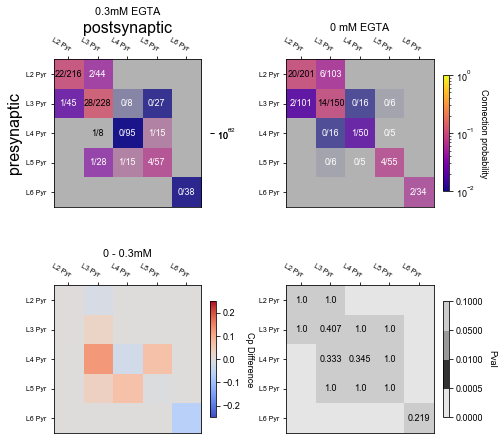

In [65]:
norm = matplotlib.colors.LogNorm(vmin=0.01, vmax=1.0, clip=True)
cmap = matplotlib.cm.get_cmap('plasma')

# define the display labels to use for each cell subclass:
human_class_labels = {
    'l2pyr': 'L2 Pyr',
    'l3pyr':   'L3 Pyr',
    'l4pyr': 'L4 Pyr',
    'l5pyr':   'L5 Pyr',
    'l6pyr': 'L6 Pyr'
}

# create a figure/axes to draw on
S9A, ax = plt.subplots(2, 2, figsize=(7, 7))
plt.subplots_adjust(wspace=0.5, top=0.5)
plt.rcParams.update({'font.size': 9})
plt.tight_layout()

# finally, draw the colormap using the provided function:
cprob_high, cprob_low, cp_stats = matrix_compare(
    ax=[ax[0, 0], ax[0, 1]], 
    results1=high_cp, 
    results2=low_cp,
    pre_cell_classes=human_cell_classes.values(), 
    post_cell_classes=human_cell_classes.values(), 
    class_labels=human_class_labels, 
    cmap=cmap, 
    norm=norm,
)
ax[0,0].set_title('0.3mM EGTA')
ax[0,1].set_title('0 mM EGTA')
ax[1,0].set_title('0 - 0.3mM')

cp_diff = cprob_high - cprob_low
cmap_diff = matplotlib.cm.get_cmap('coolwarm') 
norm_diff = matplotlib.colors.Normalize(vmin=-0.25, vmax=0.25, clip=False)
mapper = matplotlib.cm.ScalarMappable(norm=norm_diff, cmap=cmap_diff)
diff_rgba = mapper.to_rgba(cp_diff)
heatmap(diff_rgba, human_class_labels.values(), human_class_labels.values(), ax=ax[1, 0],
        cmap=cmap_diff, norm=norm_diff, 
        cbarlabel="Cp Difference", 
        cbar_kw={'shrink':0.5})

grey = matplotlib.colors.ListedColormap([(0.9, 0.9, 0.9), (0.2, 0.2, 0.2), (0.4, 0.4, 0.4), (0.6, 0.6, 0.6), (0.8, 0.8, 0.8)])
# cmap_stat = matplotlib.cm.get_cmap('tab20c_r') 
bounds = [0, 0.0005, 0.01, 0.05, 0.1]
norm_stat = matplotlib.colors.BoundaryNorm(bounds, len(bounds)+1, clip=False)
mapper = matplotlib.cm.ScalarMappable(norm=norm_stat, cmap=grey)
stat_rgba = mapper.to_rgba(cp_stats)
im, cbar = heatmap(stat_rgba, human_class_labels.values(), human_class_labels.values(), ax=ax[1,1],
        cmap=grey, norm=norm_stat, 
        cbarlabel="Pval", 
        cbar_kw={'shrink':0.5})

stat_str = np.round(cp_stats, decimals=3)
stat_str = stat_str.astype('str')
stat_str[stat_str=='0.0']=''
_ = annotate_heatmap(im, stat_str, data=cp_stats)
plt.tight_layout()

In [66]:
human_pairs = None
for pre_name, pre_class in human_cell_classes.items():
    for post_name, post_class in human_cell_classes.items():
        pair_query = db.pair_query(
            species='human',
            pre_class=pre_class,
            post_class=post_class,
            synapse=True,
        )
        
        pair_query = pair_query.add_columns(
            db.Experiment.internal,
            db.Synapse.psp_amplitude,
            db.Dynamics.pulse_amp_90th_percentile,
            db.Dynamics.stp_induction_50hz
        )
        
        df = pair_query.dataframe(rename_columns=False)
        df['pre_class'] = pre_name
        df['post_class'] = post_name
        df['pair_class'] = pre_name + "→" + post_name
        
        if human_pairs is None:
            human_pairs = df
        else:
            human_pairs = human_pairs.append(df)

In [67]:
egta_count = human_pairs.groupby(['internal', 'pair_class']).size().reset_index(name='count')
high_groups = egta_count[(egta_count['internal']=='Standard K-Gluc') & (egta_count['count']>1)]
high_groups = high_groups['pair_class']
low_groups = egta_count[(egta_count['internal']=='K-Gluc -EGTA') & (egta_count['count']>1)]
low_groups = low_groups['pair_class']
both_groups = pd.merge(high_groups, low_groups, how='inner')['pair_class']
pairs2 = human_pairs[human_pairs['pair_class'].isin(both_groups)]

In [68]:
S9B, ax = plt.subplots(3, 1, figsize=(4,6))
[x.axhline(color='k', linestyle='--', linewidth=1) for x in ax]
plt.xticks(rotation=45, ha='right')

order=['Standard K-Gluc', 'K-Gluc -EGTA']

pairs_amp = pairs2[~pairs2['psp_amplitude'].isnull()]
pairs_amp['psp_amplitude'] = pairs_amp['psp_amplitude'].astype('float64')
sns.violinplot(x='pair_class', y='psp_amplitude', data=pairs_amp, hue='internal', split=True, 
               scale='width', inner='stick', hue_order=order, ax=ax[0])
ax[0].set_xticklabels('')

pairs_amp_90 = pairs2[~pairs2['pulse_amp_90th_percentile'].isnull()]
pairs_amp_90['pulse_amp_90th_percentile'] = pairs_amp_90['pulse_amp_90th_percentile'].astype('float64')
sns.violinplot(x='pair_class', y='pulse_amp_90th_percentile', data=pairs_amp_90, hue='internal', split=True, 
               scale='width', inner='stick', hue_order=order, ax=ax[1])
ax[1].set_xticklabels('')

pairs_stp = pairs2[~pairs2['stp_induction_50hz'].isnull()]
pairs_stp['stp_induction_50hz'] = pairs_stp['stp_induction_50hz'].astype('float64')
sns.violinplot(x='pair_class', y='stp_induction_50hz', data=pairs_stp, hue='internal', split=True, 
               scale='width', inner='stick', hue_order=order, ax=ax[2])

c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

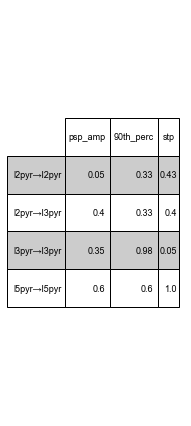

In [69]:
amp_stats = {}
amp_90_stats ={}
stp_stats = {}

for pc in both_groups:
    amp_high = pairs_amp[(pairs_amp['pair_class']==pc) & (pairs_amp['internal']=='Standard K-Gluc')]['psp_amplitude']
    amp_low = pairs_amp[(pairs_amp['pair_class']==pc) & (pairs_amp['internal']=='K-Gluc -EGTA')]['psp_amplitude']
    _, pval = stats.ks_2samp(amp_high, amp_low)
    amp_stats[pc] = pval
    
    amp_90_high = pairs_amp_90[(pairs_amp_90['pair_class']==pc) & (pairs_amp_90['internal']=='Standard K-Gluc')]['pulse_amp_90th_percentile']
    amp_90_low = pairs_amp_90[(pairs_amp_90['pair_class']==pc) & (pairs_amp_90['internal']=='K-Gluc -EGTA')]['pulse_amp_90th_percentile']
    _, pval = stats.ks_2samp(amp_90_high, amp_90_low)
    amp_90_stats[pc] = pval
    
    stp_high =  pairs_stp[(pairs_stp['pair_class']==pc) & (pairs_stp['internal']=='Standard K-Gluc')]['stp_induction_50hz']
    stp_low = pairs_stp[(pairs_stp['pair_class']==pc) & (pairs_stp['internal']=='K-Gluc -EGTA')]['stp_induction_50hz']
    if len(stp_high) == 0 or len(stp_low) == 0:
        pval = None
    else:
        _, pval = stats.ks_2samp(stp_high, stp_low)
    stp_stats[pc] = pval
    
human_stats = pd.DataFrame([amp_stats, amp_90_stats, stp_stats], index=['psp_amp', '90th_perc', 'stp']).transpose().round(decimals=2)

S9_table, ax = plt.subplots(frameon=False, figsize=(2, 6))
ax.axis('off')
ax.axis('tight')
S9_table.patch.set_visible(False)
white = (1, 1, 1)
grey = (0.8, 0.8, 0.8)
colors = np.zeros((len(human_stats), 3), dtype=(float, 3))
colors[::2, :] = grey
colors[1::2, :] = white
df_table = table(ax, human_stats, loc='center', rowColours=[c[0] for c in colors], cellColours=colors,) 
S9_table.tight_layout()
df_table.set_fontsize(9)
df_table.scale(2, 2.5)
df_table.auto_set_column_width(col=[0, 1, 2, 3])

In [72]:
label_opts = {'size': '16pt', 'font': 'arial', 'weight': 'bold'}

figure_spec = [
    {'figure': S9A, 'pos': (0, 20), 'label': 'A', 'label_opts': label_opts},
    {'figure': S9B, 'pos': (0, 500), 'label': 'B', 'label_opts': label_opts},
    {'figure': S9_table, 'pos': (300, 450), 'label': '', 'label_opts': label_opts},
]

compose_svg_figure(figure_spec, size=("6in", "10.5in"), filename=os.path.join('generated_svg', 'figureS9.svg'), display=True)

### Violin  plots of inhib-inhib connections for each layer as motivator for combining in Fig 3

In [19]:
cell_class_criteria = {
    'l23pv':     {'cre_type': 'pvalb', 'cortical_layer': '2/3', 'cell_class': 'in'},
    'l23sst':    {'cre_type': 'sst', 'cortical_layer': '2/3', 'cell_class': 'in'},
    'l23vip':    {'cre_type': 'vip', 'cortical_layer': '2/3', 'cell_class': 'in'},
    'l4pv':     {'cre_type': 'pvalb', 'cortical_layer': '4', 'cell_class': 'in'},
    'l4sst':    {'cre_type': 'sst', 'cortical_layer': '4', 'cell_class': 'in'},
    'l4vip':    {'cre_type': 'vip', 'cortical_layer': '4', 'cell_class': 'in'},
    'l5pv':     {'cre_type': 'pvalb', 'cortical_layer': '5', 'cell_class': 'in'},
    'l5sst':    {'cre_type': 'sst', 'cortical_layer': '5', 'cell_class': 'in'},
    'l5vip':    {'cre_type': 'vip', 'cortical_layer': '5', 'cell_class': 'in'},
    'l6pv':     {'cre_type': 'pvalb', 'cortical_layer': ('6a', '6b'), 'cell_class': 'in'},
    'l6sst':    {'cre_type': 'sst', 'cortical_layer': ('6a', '6b'), 'cell_class': 'in'},
    'l6vip':    {'cre_type': 'vip', 'cortical_layer': ('6a', '6b'), 'cell_class': 'in'},
}

cell_classes = {name:CellClass(name=name, **criteria) for name,criteria in cell_class_criteria.items()}

In [20]:
cells = db.query(db.Cell).join(db.Experiment).join(db.CorticalCellLocation).filter(db.Experiment.project_name.in_(['mouse V1 coarse matrix', 'mouse V1 pre-production']))
cells = cells.filter(db.Cell.cre_type.in_(['pvalb', 'sst', 'vip'])).filter(db.CorticalCellLocation.cortical_layer != None)
cells = cells.add_column(db.CorticalCellLocation.cortical_layer)
cells = cells.dataframe(rename_columns=False)
cells.head()                                        

id  experiment_id ext_id  electrode_id cre_type target_layer  \
0  4534            674      2          5384      sst            5   
1  4538            674      4          5388      sst            5   
2  4539            674      5          5389      sst            5   
3   129             23      1           177      sst            5   
4   132             23      4           180      sst            5   

                                            position     depth cell_class  \
0  [0.0012921146109042792, 0.001892350693021211, ...  0.000094         in   
1  [0.0013148558740220466, 0.0018396360905847927,...  0.000098         in   
2  [0.001210415540528131, 0.0017926421418885138, ...  0.000099         in   
3  [-0.001756850967632508, 0.0024503420809268294,...       NaN         in   
4  [-0.0017955872929398189, 0.0022971047090527327...       NaN         in   

  cell_class_nonsynaptic                                               meta  \
0                     in  {'lims_specimen_id': 1039710348, 'transgenic_c...   
1                     in  {'lims_specimen_id': 1039710361, 'transgenic_c...   
2                     in  {'lims_specimen_id': 1039710367, 'transgenic_c...   
3                     in  {'lims_specimen_id': 1032636945, 'transgenic_c...   
4                     in  {'lims_specimen_id': 1032636963, 'transgenic_c...   

  cortical_layer  
0              5  
1              5  
2              5  
3              5  
4              5

In [21]:
tab10 = sns.color_palette('tab10')
colors = [tab10[7], tab10[0], tab10[1], tab10[2], tab10[3], tab10[6]]

S12A, ax = plt.subplots(figsize=(8, 2))
sns.countplot(x='cre_type', hue='cortical_layer', data=cells, order=['pvalb', 'sst', 'vip'], 
              hue_order=['1', '2/3', '4', '5', '6a', '6b'], ax=ax, palette=colors)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('N cells')
ax.set_xlabel('Cell Subclass')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [22]:
pairs = None
for pre_name, pre_class in cell_classes.items():
    for post_name, post_class in cell_classes.items():
        pair_query = db.pair_query(
            project_name=["mouse V1 coarse matrix", 'mouse V1 pre-production'],
            pre_class=pre_class,
            post_class=post_class,
            synapse=True,
        )
        
        pair_query = pair_query.add_columns(
            db.Synapse.psp_amplitude,
            db.Synapse.psp_rise_time,
            db.Synapse.psp_decay_tau,
            db.Synapse.latency,
            db.Dynamics.pulse_amp_90th_percentile,
            db.Dynamics.stp_initial_50hz,
            db.Dynamics.stp_induction_50hz,
            db.Dynamics.stp_recovery_250ms,
            db.Dynamics.variability_resting_state,
            db.Dynamics.variability_stp_induced_state_50hz,
        )
        df = pair_query.dataframe(rename_columns=False)
        df['pre_class'] = pre_name
        df['post_class'] = post_name
        if pre_class.as_tuple[0] == post_class.as_tuple[0]:
            pair_layer = pre_class.as_tuple[0] + "→" + post_class.as_tuple[0]
            pair_layer = 'L6→L6' if '6' in pair_layer else pair_layer
        else:
            pair_layer = None
        df['pair_layer'] = pair_layer  
        df['pair_subclass'] = pre_class.as_tuple[1] + "→" + post_class.as_tuple[1]
        
        if pairs is None:
            pairs = df
        else:
            pairs = pairs.append(df)
        
pairs.head()

id experiment_id pre_cell_id post_cell_id has_synapse has_polysynapse  \
0  69361          2120       12318        12322        True           False   
1  69394          2120       12322        12318        True           False   
2  69401          2120       12322        12323        True           False   
3  64996          1965       11477        11484        True           False   
4  65033          1964       11475        11470        True           False   

  has_electrical crosstalk_artifact n_ex_test_spikes n_in_test_spikes  ...  \
0          False               None              753               58  ...   
1          False               None              584               87  ...   
2          False               None              736               60  ...   
3           True               None               87               87  ...   
4          False               None              536              536  ...   

   pulse_amp_90th_percentile  stp_initial_50hz  stp_induction_50hz  \
0                        NaN               NaN                 NaN   
1                        NaN               NaN                 NaN   
2                        NaN               NaN                 NaN   
3                        NaN               NaN                 NaN   
4                  -0.000196         -0.093958           -0.284385   

  stp_recovery_250ms variability_resting_state  \
0                NaN                       NaN   
1                NaN                       NaN   
2                NaN                       NaN   
3                NaN                       NaN   
4          -0.196931                       NaN   

  variability_stp_induced_state_50hz pre_class post_class pair_layer  \
0                                NaN     l23pv      l23pv  L2/3→L2/3   
1                                NaN     l23pv      l23pv  L2/3→L2/3   
2                                NaN     l23pv      l23pv  L2/3→L2/3   
3                                NaN     l23pv      l23pv  L2/3→L2/3   
4                           0.158353     l23pv      l23pv  L2/3→L2/3   

   pair_subclass  
0    pvalb→pvalb  
1    pvalb→pvalb  
2    pvalb→pvalb  
3    pvalb→pvalb  
4    pvalb→pvalb  

[5 rows x 29 columns]

In [24]:
def kw_stats(df, metric):
#     print('Kruskal-Wallis Test for %s across layers' % metric)
    subclasses = df['pair_subclass'].dropna().unique()
    kw={}
    for subclass in subclasses:
        sub_df = df[df['pair_subclass']==subclass]
        layers = sub_df['pair_layer'].dropna().unique()
        kw[subclass] = np.float('nan')
        if len(layers) < 2:
            continue
        else: 
            l1_values = sub_df[sub_df['pair_layer']==layers[0]][metric]
            l2_values = sub_df[sub_df['pair_layer']==layers[1]][metric]
            h, p = stats.kruskal(l1_values, l2_values, nan_policy='omit')
            try:
                l3_values = sub_df[sub_df['pair_layer']==layers[2]][metric]
                h, p = stats.kruskal(l1_values, l2_values, l3_values, nan_policy='omit')
            except IndexError:
#                 print('%s: %0.5f' % (subclass, p))
                kw[subclass] = p
                continue
            try:
                l4_values = sub_df[sub_df['pair_layer']==layers[3]][metric]
                h, p = stats.kruskal(l1_values, l2_values, l3_values, l4_values, nan_policy='omit')
            except IndexError:
#                 print('%s: %0.5f' % (subclass, p))
                kw[subclass] = p
                continue
#             h, p = stats.kruskal(l1_values, l2_values, l3_values, l4_values, nan_policy='raise')
#             print('%s: %0.5f' % (subclass, p))
            kw[subclass] = p
    kw_df = pd.DataFrame.from_dict(kw, orient='index', columns=['KW P-val']).round(decimals=3)
    return kw_df

def stats_table(df, ax):
    ax.axis('off')
    ax.axis('tight')
    white = (1, 1, 1)
    grey = (0.8, 0.8, 0.8)
    colors = np.zeros((1, len(df)), dtype=(float, 3))
    colors[::2, :] = grey
    colors[1::2, :] = white
    df_table = table(ax, df.transpose(), loc='center', rowColours=[c[0] for c in colors], cellColours=colors,) 
    df_table.set_fontsize(9.7)
    df_table.scale(1, 1.5)
    df_table.auto_set_column_width(col=np.arange(len(df)))

In [25]:
sns.set_palette('tab10')
S12B, ax = plt.subplots(2, 1, figsize=(8, 4))

pairs_latency = pairs[~pairs['latency'].isnull()]
pairs_latency['latency'] = pairs_latency['latency'].astype('float64')*1e3
sns.violinplot(x='pair_subclass', y='latency', data=pairs_latency, hue='pair_layer',  scale='width', inner='sticks', ax=ax[0], cut=0.5)
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_ylabel('Latency (ms)')

latency_kw = kw_stats(pairs_latency, 'latency')
stats_table(latency_kw, ax[1])
S12B.subplots_adjust(hspace=0.005)


c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


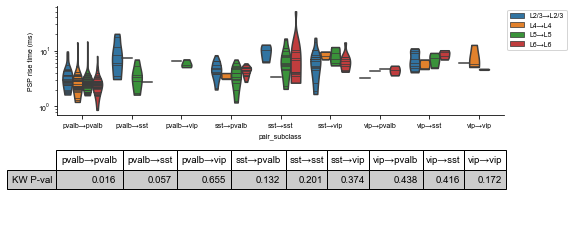

In [26]:
S12C, ax = plt.subplots(2, 1, figsize=(8, 4))

pairs_rt = pairs[~pairs['psp_rise_time'].isnull()]
pairs_rt['psp_rise_time'] = pairs_rt['psp_rise_time'].astype('float64')*1e3
sns.violinplot(x='pair_subclass', y='psp_rise_time', data=pairs_rt, hue='pair_layer',  scale='width', inner='sticks',ax=ax[0], cut=0.1)

ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_yscale('log')
ax[0].set_ylabel('PSP rise time (ms)')

rt_kw = kw_stats(pairs_rt, 'psp_rise_time')
stats_table(rt_kw, ax[1])
S12C.subplots_adjust(hspace=0.005)


c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


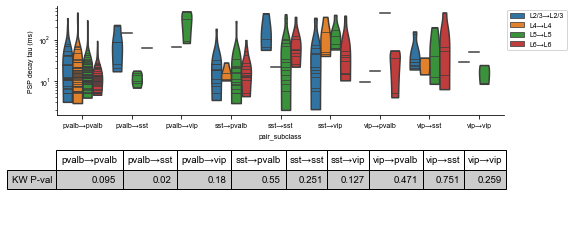

In [27]:
S12D, ax = plt.subplots(2, 1, figsize=(8, 4))

pairs_dt = pairs[~pairs['psp_decay_tau'].isnull()]
pairs_dt['psp_decay_tau'] = pairs_dt['psp_decay_tau'].astype('float64')
pairs_dt = pairs_dt[pairs_dt['psp_decay_tau'] < 0.49]
pairs_dt['psp_decay_tau'] *= 1e3
sns.violinplot(x='pair_subclass', y='psp_decay_tau', data=pairs_dt, hue='pair_layer',  scale='width', inner='sticks',ax=ax[0], cut=0.05)

ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_yscale('log')
ax[0].set_ylabel('PSP decay tau (ms)')

dt_kw = kw_stats(pairs_dt, 'psp_decay_tau')
stats_table(dt_kw, ax[1])
S12D.subplots_adjust(hspace=0.005)

c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


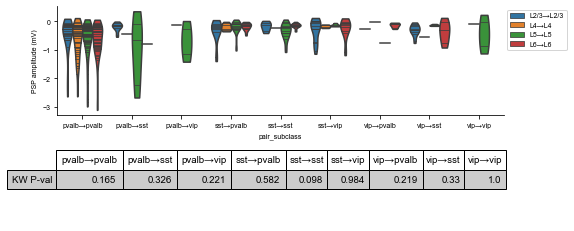

In [28]:
S12E, ax = plt.subplots(2, 1, figsize=(8, 4))

pairs_amp = pairs[~pairs['psp_amplitude'].isnull()]
pairs_amp['psp_amplitude'] = pairs_amp['psp_amplitude'].astype('float64')*1e3
sns.violinplot(x='pair_subclass', y='psp_amplitude', data=pairs_amp, hue='pair_layer',  scale='width', inner='sticks', ax=ax[0], cut=0.5)

ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_ylabel('PSP amplitude (mV)')

amp_kw = kw_stats(pairs_amp, 'psp_amplitude')
stats_table(amp_kw, ax[1])
S12E.subplots_adjust(hspace=0.005)

In [29]:
S12F, ax = plt.subplots(2, 1, figsize=(8, 4))

pairs_amp_90 = pairs[~pairs['pulse_amp_90th_percentile'].isnull()]
pairs_amp_90['pulse_amp_90th_percentile'] = pairs_amp_90['pulse_amp_90th_percentile'].astype('float64')*1e3
sns.violinplot(x='pair_subclass', y='pulse_amp_90th_percentile', data=pairs_amp_90, hue='pair_layer',  scale='width', inner='sticks', ax=ax[0], cut=0.5)

ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_ylabel('90th percentile\nPSP amplitude (mV)')

amp_90_kw = kw_stats(pairs_amp_90, 'pulse_amp_90th_percentile')
stats_table(amp_90_kw, ax[1])
S12F.subplots_adjust(hspace=0.005)

c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [30]:
label_opts = {'size': '16pt', 'font': 'arial', 'weight': 'bold'}

figure_spec = [
    {'figure': S12A, 'pos': (0, 20), 'label': 'A', 'label_opts': label_opts},
    {'figure': S12B, 'pos': (0, 155), 'label': 'B', 'label_opts': label_opts},
    {'figure': S12C, 'pos': (0, 360), 'label': 'C', 'label_opts': label_opts},
    {'figure': S12D, 'pos': (0, 575), 'label': 'D', 'label_opts': label_opts},
    {'figure': S12E, 'pos': (0, 780), 'label': 'E', 'label_opts': label_opts},
    {'figure': S12F, 'pos': (0, 990), 'label': 'F', 'label_opts': label_opts},
]

compose_svg_figure(figure_spec, size=("7in", "13in"), filename=os.path.join('generated_svg', 'figureS12.svg'), display=True)

c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


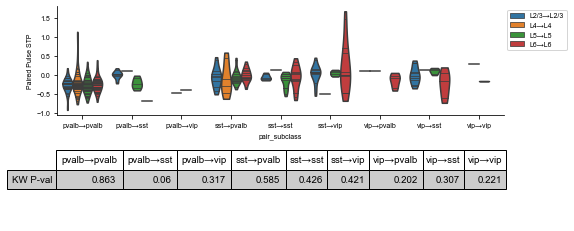

In [31]:
S13A, ax = plt.subplots(2, 1, figsize=(8, 4))

paired_pulse = pairs[~pairs['stp_initial_50hz'].isnull()]
paired_pulse['stp_initial_50hz'] = paired_pulse['stp_initial_50hz'].astype('float64')
sns.violinplot(x='pair_subclass', y='stp_initial_50hz', data=paired_pulse, hue='pair_layer',  scale='width', inner='sticks', ax=ax[0], cut=0.5)

ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_ylabel('Paired Pulse STP')

amp_kw = kw_stats(paired_pulse, 'stp_initial_50hz')
stats_table(amp_kw, ax[1])
S13A.subplots_adjust(hspace=0.005)

c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


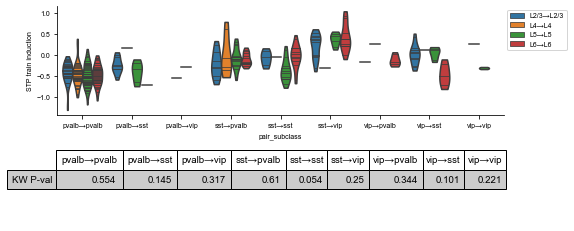

In [32]:
S13B, ax = plt.subplots(2, 1, figsize=(8, 4))

stp_ind = pairs[~pairs['stp_induction_50hz'].isnull()]
stp_ind['stp_induction_50hz'] = stp_ind['stp_induction_50hz'].astype('float64')
sns.violinplot(x='pair_subclass', y='stp_induction_50hz', data=stp_ind, hue='pair_layer',  scale='width', inner='sticks', ax=ax[0], cut=0.5)

ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_ylabel('STP train induction')

amp_kw = kw_stats(stp_ind, 'stp_induction_50hz')
stats_table(amp_kw, ax[1])
S13B.subplots_adjust(hspace=0.005)

In [33]:
S13C, ax = plt.subplots(2, 1, figsize=(8, 4))

stp_rec = pairs[~pairs['stp_recovery_250ms'].isnull()]
stp_rec['stp_recovery_250ms'] = stp_rec['stp_recovery_250ms'].astype('float64')
sns.violinplot(x='pair_subclass', y='stp_recovery_250ms', data=stp_rec, hue='pair_layer',  scale='width', inner='sticks', ax=ax[0], cut=0.5)

ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_ylabel('STP Recovery')

amp_kw = kw_stats(stp_rec, 'stp_recovery_250ms')
stats_table(amp_kw, ax[1])
S13C.subplots_adjust(hspace=0.005)

c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


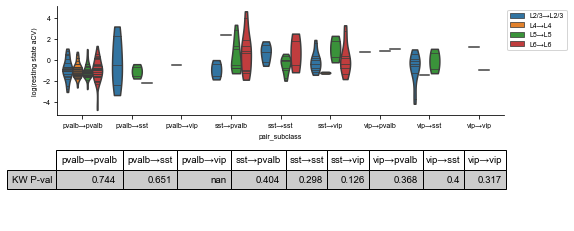

In [34]:
S13D, ax = plt.subplots(2, 1, figsize=(8, 4))

var_rs = pairs[~pairs['variability_resting_state'].isnull()]
var_rs['variability_resting_state'] = var_rs['variability_resting_state'].astype('float64')
sns.violinplot(x='pair_subclass', y='variability_resting_state', data=var_rs, hue='pair_layer',  scale='width', inner='sticks', ax=ax[0], cut=0.5)

ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_ylabel('log(resting state aCV)')

amp_kw = kw_stats(var_rs, 'variability_resting_state')
stats_table(amp_kw, ax[1])
S13D.subplots_adjust(hspace=0.005)

c:\users\stephanies\appdata\local\continuum\miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


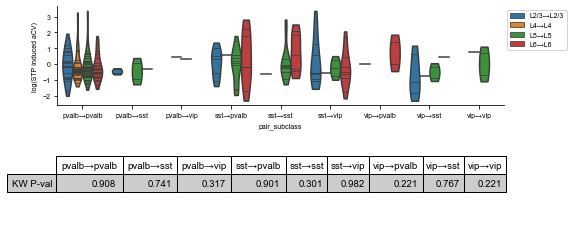

In [35]:
S13E, ax = plt.subplots(2, 1, figsize=(8, 4))

var_ind = pairs[~pairs['variability_stp_induced_state_50hz'].isnull()]
var_ind['variability_stp_induced_state_50hz'] = var_ind['variability_stp_induced_state_50hz'].astype('float64')
sns.violinplot(x='pair_subclass', y='variability_stp_induced_state_50hz', data=var_ind, hue='pair_layer',  scale='width', inner='sticks', ax=ax[0], cut=0.5)

ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_ylabel('log(STP induced aCV)')

amp_kw = kw_stats(var_ind, 'variability_stp_induced_state_50hz')
stats_table(amp_kw, ax[1])
S13D.subplots_adjust(hspace=0.005)

In [36]:
label_opts = {'size': '16pt', 'font': 'arial', 'weight': 'bold'}

figure_spec = [
    {'figure': S13A, 'pos': (0, 20), 'label': 'A', 'label_opts': label_opts},
    {'figure': S13B, 'pos': (0, 225), 'label': 'B', 'label_opts': label_opts},
    {'figure': S13C, 'pos': (0, 430), 'label': 'C', 'label_opts': label_opts},
    {'figure': S13D, 'pos': (0, 635), 'label': 'D', 'label_opts': label_opts},
    {'figure': S13E, 'pos': (0, 840), 'label': 'E', 'label_opts': label_opts},
]

compose_svg_figure(figure_spec, size=("7in", "13in"), filename=os.path.join('generated_svg', 'figureS13.svg'), display=True)

### Fig S11 Holding potential

In [37]:
from aisynphys.avg_response_fit import response_query
from aisynphys.ui.notebook import cell_class_matrix, heatmap, annotate_heatmap
import matplotlib.colors, matplotlib.cm
from sklearn.linear_model import LinearRegression, HuberRegressor
import matplotlib.pyplot as plt

In [38]:
cell_class_criteria = {
    'l23pyr': {'cell_class': 'ex', 'cortical_layer': '2/3'},
    'l4pyr':  {'cre_type': ('nr5a1', 'rorb'), 'cell_class': 'ex'},
    'l5et':   {'cre_type': ('sim1', 'fam84b'), 'cell_class': 'ex'},
    'l5it':   {'cre_type': 'tlx3', 'cell_class': 'ex'}, 
    'l6pyr':  {'cre_type': 'ntsr1', 'cell_class': 'ex'},
    'pv':     {'cre_type': 'pvalb', 'cell_class': 'in'},
    'sst':    {'cre_type': 'sst', 'cell_class': 'in'},
    'vip':    {'cre_type': 'vip', 'cell_class': 'in'},  
}

cell_classes = {name:CellClass(name=name, **criteria) for name,criteria in cell_class_criteria.items()}

class_labels = {
    'l23pyr': 'L2/3 Pyr\n spiny',
    'l4pyr':  'L4 Pyr\n nr5a1',
    'l5et':   'L5 ET\n sim1, mscRE4',
    'l5it':   'L5 IT\n tlx3', 
    'l6pyr':  'L6 Pyr\n ntsr1',
    'pv':     'Pv',
    'sst':    'Sst',
    'vip':    'Vip',
}

pair_query_args = {
    'project_name': ['mouse V1 pre-production', 'mouse V1 coarse matrix'],
    'synapse': True,
}

In [39]:
pairs = None
for pre_name, pre_class in cell_classes.items():
    for post_name, post_class in cell_classes.items():

        pair_query = db.pair_query(
            project_name=["mouse V1 coarse matrix", 'mouse V1 pre-production'],
            pre_class=pre_class,
            post_class=post_class,
            synapse=True,
        )
        
        pair_query = pair_query.add_columns(
            db.Synapse.psp_amplitude,
            db.Synapse.synapse_type,
            db.Conductance.effective_conductance,
            db.Conductance.adj_psp_amplitude,
            db.Conductance.reversal_potential,
            db.Conductance.ideal_holding_potential,
            db.Conductance.avg_baseline_potential,
            db.Dynamics.variability_resting_state,
        )
        df = pair_query.dataframe()
        df['pre_class'] = pre_name
        df['post_class'] = post_name
        df['pair_class'] = pre_name + "→" + post_name

        if pairs is None:
            pairs = df
        else:
            pairs = pairs.append(df)
            
print(len(pairs))

1341


In [40]:
pairs.head()

pair.id  pair.experiment_id  pair.pre_cell_id  pair.post_cell_id  \
0    34970                 914              5753               5752   
1    69776                2135             12404              12402   
2    33696                 869              5513               5515   
3    74079                2294             13247              13248   
4    73757                2284             13187              13188   

  pair.has_synapse pair.has_polysynapse pair.has_electrical  \
0             True                False               False   
1             True                False               False   
2             True                False               False   
3             True                False               False   
4             True                False               False   

   pair.crosstalk_artifact  pair.n_ex_test_spikes  pair.n_in_test_spikes  ...  \
0                      NaN                    613                     60  ...   
1                      NaN                    616                    517  ...   
2                      NaN                    524                     60  ...   
3                      NaN                    444                     60  ...   
4                      NaN                    754                    240  ...   

   synapse.synapse_type  conductance.effective_conductance  \
0                    ex                                NaN   
1                    ex                            0.00071   
2                    ex                                NaN   
3                    ex                            0.00105   
4                    ex                           -0.00089   

   conductance.adj_psp_amplitude  conductance.reversal_potential  \
0                            NaN                             NaN   
1                       0.000028                       -0.109659   
2                            NaN                             NaN   
3                       0.000085                       -0.150780   
4                       0.000068                        0.006498   

  conductance.ideal_holding_potential  conductance.avg_baseline_potential  \
0                                 NaN                                 NaN   
1                               -0.07                           -0.053954   
2                                 NaN                                 NaN   
3                               -0.07                           -0.065152   
4                               -0.07                           -0.068766   

  dynamics.variability_resting_state  pre_class  post_class     pair_class  
0                                NaN     l23pyr      l23pyr  l23pyr→l23pyr  
1                           0.986962     l23pyr      l23pyr  l23pyr→l23pyr  
2                                NaN     l23pyr      l23pyr  l23pyr→l23pyr  
3                          -1.043523     l23pyr      l23pyr  l23pyr→l23pyr  
4                           1.076628     l23pyr      l23pyr  l23pyr→l23pyr  

[5 rows x 26 columns]

In [41]:
inh_pairs = pairs[(pairs['synapse.synapse_type']=='in') & (~pairs['synapse.psp_amplitude'].isna()) & (~pairs['conductance.effective_conductance'].isna()) & (~pairs['conductance.adj_psp_amplitude'].isna())]
inh_pairs.head()

pair.id  pair.experiment_id  pair.pre_cell_id  pair.post_cell_id  \
3     75525                2340             13513              13518   
5    100337                3221             18231              18230   
7     94778                3036             17194              17187   
8     99586                3191             18078              18075   
13    88100                2795             15918              15922   

   pair.has_synapse pair.has_polysynapse pair.has_electrical  \
3              True                False               False   
5              True                False               False   
7              True                False               False   
8              True                False               False   
13             True                False               False   

    pair.crosstalk_artifact  pair.n_ex_test_spikes  pair.n_in_test_spikes  \
3                       NaN                    443                    383   
5                       NaN                    788                    728   
7                       NaN                    447                    339   
8                       NaN                    563                    503   
13                      NaN                    192                    132   

    ...  synapse.synapse_type  conductance.effective_conductance  \
3   ...                    in                          -0.043172   
5   ...                    in                          -0.068771   
7   ...                    in                          -0.030906   
8   ...                    in                          -0.014072   
13  ...                    in                          -0.039779   

    conductance.adj_psp_amplitude  conductance.reversal_potential  \
3                       -0.000598                       -0.068856   
5                       -0.001196                       -0.072387   
7                       -0.000444                       -0.069351   
8                       -0.000251                       -0.072858   
13                      -0.000395                       -0.064919   

   conductance.ideal_holding_potential  conductance.avg_baseline_potential  \
3                               -0.055                           -0.053135   
5                               -0.055                           -0.055469   
7                               -0.055                           -0.052736   
8                               -0.055                           -0.051726   
13                              -0.055                           -0.056067   

   dynamics.variability_resting_state  pre_class  post_class  pair_class  
3                           -1.424398         pv      l23pyr   pv→l23pyr  
5                           -0.722742         pv      l23pyr   pv→l23pyr  
7                           -0.794234         pv      l23pyr   pv→l23pyr  
8                            0.384701         pv      l23pyr   pv→l23pyr  
13                                NaN         pv      l23pyr   pv→l23pyr  

[5 rows x 26 columns]

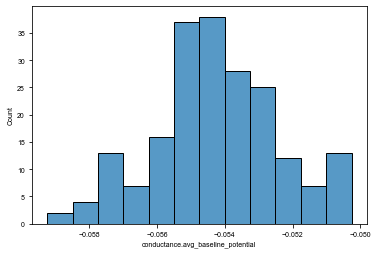

In [42]:
sns.histplot(data=inh_pairs, x='conductance.avg_baseline_potential')

In [43]:
inh_pairs.describe()['conductance.avg_baseline_potential']

count    202.000000
mean      -0.054249
std        0.001844
min       -0.059238
25%       -0.055275
50%       -0.054370
75%       -0.053058
max       -0.050262
Name: conductance.avg_baseline_potential, dtype: float64

In [57]:
pair_id = 67126

q = db.query(db.PatchClampRecording.access_adj_baseline_potential, db.PulseResponseFit.fit_amp)
q = q.join(db.PulseResponse, db.PulseResponse.recording_id==db.PatchClampRecording.recording_id)
q = q.join(db.PulseResponseFit, db.PulseResponseFit.pulse_response_id==db.PulseResponse.id)
q = q.join(db.Pair, db.PulseResponse.pair_id==db.Pair.id)
q = q.filter(db.Pair.id==pair_id)
one_pair = q.dataframe()
one_pair['patch_clamp_recording.access_adj_baseline_potential']*=1e3
one_pair['pulse_response_fit.fit_amp']*=1e12
one_pair.head()

patch_clamp_recording.access_adj_baseline_potential  \
0                                         -71.102407     
1                                         -71.102407     
2                                         -71.102407     
3                                         -71.102407     
4                                         -71.102407     

   pulse_response_fit.fit_amp  
0                   -2.363347  
1                    4.423484  
2                    3.364025  
3                    3.672105  
4                    1.340922

-75.89953083915634


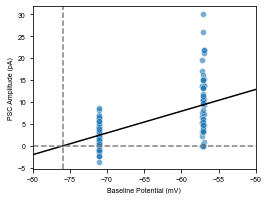

In [61]:
one_pair = one_pair.dropna()
baseline_potential = one_pair['patch_clamp_recording.access_adj_baseline_potential'].to_numpy()
pulse_amp = one_pair['pulse_response_fit.fit_amp'].to_numpy()

model = LinearRegression().fit(baseline_potential.reshape((-1,1)), pulse_amp)
slope = model.coef_ 
intercept = model.intercept_

def abline(slope, intercept, ax):
    """Plot a line from slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, color='black')

figS11A, ax = plt.subplots(figsize=(4, 3))
sns.scatterplot(data=one_pair, x='patch_clamp_recording.access_adj_baseline_potential', y='pulse_response_fit.fit_amp', alpha=0.6, ax=ax)
ax.set_xlim(-80, -50)
ax.set_xlabel('Baseline Potential (mV)')
ax.set_ylabel('PSC Amplitude (pA)')

abline(slope, intercept, ax)
reversal = inh_pairs[inh_pairs['pair.id']==pair_id]['conductance.reversal_potential'].iloc[0]*1e3
ax.axvline(reversal, ls='--', color='grey')
ax.axhline(0, ls='--', color='grey')
print(reversal)

In [59]:
inh_pairs_copy = inh_pairs.copy()
inh_pairs_copy['synapse.psp_amplitude']*=1e3
inh_pairs_copy['conductance.adj_psp_amplitude']*=1e3
inh_pairs_copy['conductance.avg_baseline_potential']*=1e3
inh_pairs_copy['conductance.reversal_potential']*=1e3

mean_pr_amp = inh_pairs_copy['synapse.psp_amplitude'].to_numpy()
predicted_amp = inh_pairs_copy['conductance.adj_psp_amplitude'].to_numpy()
effective_cond = inh_pairs_copy['conductance.effective_conductance'].to_numpy()

predicted_amp_model = LinearRegression().fit(mean_pr_amp.reshape((-1,1)), predicted_amp)
predicted_amp_slope = predicted_amp_model.coef_ 
predicted_amp_intercept = predicted_amp_model.intercept_
print("R2: %0.2f, slope: %0.2f" % (predicted_amp_model.score(mean_pr_amp.reshape((-1,1)), predicted_amp), predicted_amp_slope))

conductance_model = LinearRegression().fit(mean_pr_amp.reshape((-1,1)), effective_cond)
conductance_slope = conductance_model.coef_
conductance_intercept = conductance_model.intercept_
print("R2: %0.2f" % (conductance_model.score(mean_pr_amp.reshape((-1,1)), effective_cond)))

R2: 0.88, slope: 0.94
R2: 0.42


In [60]:
figS11B, ax = plt.subplots(figsize=(4,3))

sns.scatterplot(data=inh_pairs_copy, x='conductance.avg_baseline_potential', y='synapse.psp_amplitude', alpha=0.6, ax=ax, color='grey')

ax.set_xlabel('Avg Baseline Potential (mV)')
ax.set_ylabel('PSP Amplitude (mV)')

hyperpol_pair = 117361
depol_pair = 99586
ax.axvline(-55, color='grey', ls='--')
for pair, color in {pair_id: 'b', hyperpol_pair: 'g', depol_pair: 'orange'}.items():

    one_pair2 = inh_pairs_copy[inh_pairs_copy['pair.id']==pair]

    x1 = one_pair2['conductance.avg_baseline_potential'].iloc[0]
    y1 = one_pair2['synapse.psp_amplitude'].iloc[0]
    x2 = one_pair2['conductance.reversal_potential'].iloc[0]
    y2 = 0

    m = (y2 - y1) / (x2 - x1)
    b = -m * x2
    y = m * -55 + b
 
    ax.plot(x1, y1, 'o', markersize=8, color=color)
    if x1 < -55:
        ax.plot([-55, x2], [y, y2], color=color)
    else:
        ax.plot([x1, x2], [y1, y2], color=color)
    ax.plot(-55, y, 's', markersize=8, color=color)
                
ax.axhline(0, color='grey', ls='--')

ax.set_xlim(-60, -50)

(-60, -50)

In [48]:
inh_pairs[inh_pairs.duplicated(subset='pair.id')]

pair.id  pair.experiment_id  pair.pre_cell_id  pair.post_cell_id  \
6    100337                3221             18231              18230   
9     99586                3191             18078              18075   
23    93586                3002             16982              16979   
12    88193                2798             15938              15934   
14    96207                3084             17461              17465   

   pair.has_synapse pair.has_polysynapse pair.has_electrical  \
6              True                False               False   
9              True                False               False   
23             True                False               False   
12             True                False               False   
14             True                False               False   

    pair.crosstalk_artifact  pair.n_ex_test_spikes  pair.n_in_test_spikes  \
6                       NaN                    788                    728   
9                       NaN                    563                    503   
23                      NaN                    598                    538   
12                      NaN                    359                    275   
14                      NaN                    540                    480   

    ...  synapse.synapse_type  conductance.effective_conductance  \
6   ...                    in                          -0.068771   
9   ...                    in                          -0.014072   
23  ...                    in                          -0.072017   
12  ...                    in                          -0.005893   
14  ...                    in                          -0.007646   

    conductance.adj_psp_amplitude  conductance.reversal_potential  \
6                       -0.001196                       -0.072387   
9                       -0.000251                       -0.072858   
23                      -0.000270                       -0.058749   
12                      -0.000095                       -0.071171   
14                      -0.000133                       -0.072408   

   conductance.ideal_holding_potential  conductance.avg_baseline_potential  \
6                               -0.055                           -0.055469   
9                               -0.055                           -0.051726   
23                              -0.055                           -0.053297   
12                              -0.055                           -0.050589   
14                              -0.055                           -0.053288   

   dynamics.variability_resting_state  pre_class  post_class  pair_class  
6                           -0.722742         pv       l4pyr    pv→l4pyr  
9                            0.384701         pv       l4pyr    pv→l4pyr  
23                          -0.482772         pv       l4pyr    pv→l4pyr  
12                                NaN        sst       l4pyr   sst→l4pyr  
14                                NaN        sst       l4pyr   sst→l4pyr  

[5 rows x 26 columns]

In [62]:
def abline(slope, intercept, ax):
    """Plot a line from slope and intercept"""
    y_vals = np.array(ax.get_ylim())
    x_vals = intercept + slope * y_vals
    ax.plot(x_vals, y_vals, color='grey')
    
figS11C, ax = plt.subplots(2, 1, figsize=(4, 5))
sns.scatterplot(data=inh_pairs_copy, y='synapse.psp_amplitude', x='conductance.effective_conductance', ax=ax[0], alpha=0.6, color='grey')
#                hue='conductance.avg_baseline_potential')
# ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[0].set_ylim(-3, 0.1)
ax[1].set_xlim(-0.3, 0.05)
ax[0].set_ylabel('')
ax[0].set_xlabel('Effective Conductance')
abline(conductance_slope, conductance_intercept, ax[0])


sns.scatterplot(data=inh_pairs_copy, y='synapse.psp_amplitude', x='conductance.adj_psp_amplitude', ax=ax[1], alpha=0.6, color='grey')
#                hue='conductance.avg_baseline_potential')
# ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[1].set_ylim(-3, 0.1)
ax[1].set_xlim(-3, 0.1)
ax[1].set_ylabel('')
ax[1].set_xlabel('Adj PSP Amplitude (mV)')
abline(predicted_amp_slope, predicted_amp_intercept, ax[1])

for pair, color in {pair_id: 'b', hyperpol_pair: 'g', depol_pair: 'orange'}.items():

    one_pair2 = inh_pairs_copy[inh_pairs_copy['pair.id']==pair]
    psp_amp = one_pair2['synapse.psp_amplitude'].iloc[0]
    cond = one_pair2['conductance.effective_conductance'].iloc[0]
    adj_amp = one_pair2['conductance.adj_psp_amplitude'].iloc[0]
    
    ax[0].plot(cond, psp_amp, marker='o', color=color)
    ax[1].plot(adj_amp, psp_amp, marker='o', color=color)


figS11C.text(-0.05, 0.5, 'PSP amplitude (mV)', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()

In [53]:
def data_matrix_nonsquare(data_df, pre_cell_classes, post_cell_classes, metric=None, scale=1, unit='', cmap=None, norm=None, alpha=2):
    """ Return data and labels to make a matrix using heatmap and annotate_heatmap. Similar to 
    show_connectivity_matrix but for arbitrary data metrics.

    Parameters:
    -----------
    data_df : pandas dataframe 
        pairs with various metrics as column names along with the pre-class and post-class.
    cell_classes : list 
        cell classes included in the matrix, this assumes a square matrix.
    metric : str
        data metric to be displayed in matrix
    scale : float
        scale of the data
    unit : str
        unit for labels
    cmap : matplotlib colormap instance
        used to colorize the matrix
    norm : matplotlib normalize instance
        used to normalize the data before colorizing
    alpha : int
        used to desaturate low confidence data
    """

    shape = (len(pre_cell_classes), len(post_cell_classes))
    data = np.zeros(shape)
    data_alpha = np.zeros(shape)
    data_str = np.zeros(shape, dtype=object)
    
    mean = data_df.groupby(['pre_class', 'post_class']).aggregate(lambda x: np.mean(x))
    error = data_df.groupby(['pre_class', 'post_class']).aggregate(lambda x: np.std(x))
    count = data_df.groupby(['pre_class', 'post_class']).count()
    
    for i, pre_class in enumerate(pre_cell_classes):
        for j, post_class in enumerate(post_cell_classes):
            try:
                value = mean.loc[pre_class].loc[post_class][metric]
                std = error.loc[pre_class].loc[post_class][metric]
                n = count.loc[pre_class].loc[post_class][metric]
                if n == 1:
                    value = np.nan
                #data_df.loc[pre_class].loc[post_class][metric]
            except KeyError:
                value = np.nan
            data[i, j] = value*scale
            data_str[i, j] = "%0.2f" % (value*scale) if np.isfinite(value) else ""
            data_alpha[i, j] = 1-alpha*((std*scale)/np.sqrt(n)) if np.isfinite(value) else 0 


    mapper = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
    data_rgb = mapper.to_rgba(data)
    max = mean[metric].max()*scale
    data_rgb[:,:,3] = np.clip(data_alpha, 0, 1)
    return data_rgb, data_str

In [54]:
cmap = matplotlib.cm.get_cmap('bwr')
g_norm = matplotlib.colors.Normalize(vmin=-0.1, vmax=0.1, clip=False)
amp_norm = matplotlib.colors.Normalize(vmin=-1.5, vmax=1.5, clip=False)

pre_classes = {name: cell_class for name, cell_class in cell_classes.items() if name in ['pv', 'sst', 'vip']}
pre_labels = {name: label for name, label in class_labels.items() if name in ['pv', 'sst', 'vip']}

adj_amp_rgb, adj_amp_str = data_matrix_nonsquare(inh_pairs, pre_classes, cell_classes, metric='conductance.adj_psp_amplitude', scale=1e3, unit='mV', cmap=cmap, norm=amp_norm, alpha=1)
amp_rgb, amp_str = data_matrix_nonsquare(inh_pairs, pre_classes, cell_classes, metric='synapse.psp_amplitude', scale=1e3, unit='mV', cmap=cmap, norm=amp_norm, alpha=1)

figS11D, ax = plt.subplots(2, 1, figsize=(5, 5))

amp_im, cbar = heatmap(
        amp_rgb, pre_labels, class_labels,
        ax=ax[0],
        ax_labels=('postsynaptic', 'presynaptic'),
        bg_color=(0.8, 0.8, 0.8),
        cmap=cmap,
        norm=amp_norm,
        cbar_kw={'shrink':0.5, 'pad':0.02, 'orientation':'horizontal'},
    )
cbar.ax.set_xlabel('PSP Amplitude (mV)', fontsize=10)
text = annotate_heatmap(amp_im, amp_str, data=amp_str, fontsize=8)


adj_amp_im, cbar = heatmap(
        adj_amp_rgb, pre_labels, class_labels,
        ax=ax[1],
#         ax_labels=('postsynaptic', 'presynaptic'),
        bg_color=(0.8, 0.8, 0.8),
        cmap=cmap,
        norm=amp_norm,
        cbar_kw={'shrink':0.5, 'pad':0.02, 'orientation': 'horizontal'},
    )
cbar.ax.set_xlabel('Adj PSP Amplitude', fontsize=10)
text = annotate_heatmap(adj_amp_im, adj_amp_str, data=adj_amp_str, fontsize=8)

plt.tight_layout()

In [63]:
label_opts = {'size': '16pt', 'font': 'arial', 'weight': 'bold'}

figure_spec = [
    {'figure': figS11A, 'pos': (0, 20), 'label': 'A', 'label_opts': label_opts},
    {'figure': figS11B, 'pos': (330, 20), 'label': 'B', 'label_opts': label_opts},
    {'figure': figS11C, 'pos': (0, 250), 'label': 'C', 'label_opts': label_opts},
    {'figure': figS11D, 'pos': (330, 250), 'label': 'D', 'label_opts': label_opts},
    
]

compose_svg_figure(figure_spec, size=("10in", "10in"), filename=os.path.join('generated_svg', 'figure_S11.svg'), display=True)